  # Введение
Заказчик — коммерческий департамент компании «Мегалайн». Исследование направленное на определение тарифа, сильнее всего влияющего на доход компании. Сравнение будет проводиться между тарифами «Смарт» и «Ультра». Результат исследования будет использоваться для корректирования рекламного бюджета.
  
                                                  
                                                  
**Тариф «Смарт»**                                                    

Ежемесячная плата: 550 рублей                        
В тариф включено:                                     

- 500 минут разговора                                    

- 50 сообщений

- 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

- минута разговора: 3 рубля

- сообщение: 3 рубля

- 1 Гб интернет-трафика: 200 рублей


**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей
В тариф включено:

- 3000 минут разговора
- 1000 сообщений
- 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

 **Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.
 Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

                                        
   **Задача:**

1. Провести первичный анализ данных
2. Провести предобработку данных (привести к нужным типам и исправить ошибки)
3. Добавить необходимые данные в таблицы (количество сделанных звонков и израсходованных минут разговора по месяцам; количество отправленных сообщений по месяцам; объем израсходованного интернет-трафика по месяцам; помесячную выручку с каждого пользователя)
4. Описать поведение клиентов (среднее кол-во сообщений, минут разговора, объем трафика)
5. Проверить гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


### Откроем файлы с данными и изучим общую информацию

   **Импортирование необходимых данных**

In [846]:
import pandas as pd
from IPython.display import display
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

**Изучим данные из файла tariffs**

In [847]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


1. Для удобства переведем мегабайты в гигабайты, чтобы вести все дальнейшие расчеты в ГБ, т.к. сверх тарифа идет ст-ть ГБ. 2. Поменяем  порядок столбцов для наглядности.

In [848]:
tariffs['gb_included']=(tariffs['mb_per_month_included']/1024).astype('int64')
tariffs=tariffs[['tariff_name', 'messages_included', 'gb_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute']]
display(tariffs.head())

,tariff_name,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


**Изучим данных из файла calls**

In [849]:
calls.info()
calls.describe() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [850]:
display(calls.head()) 


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


 Есть звонки продолжительностью 0 минут, это, скорее всего, неотвеченные. Не будем их убирать, они никак не повлияют. Пропущенных значений нет.

In [851]:
#переведем время в формат даты
#добавим месяц
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].astype('datetime64[M]')
calls['duration'] = np.ceil(calls['duration']).astype('Int64') #округляем до целого в большую сторону

In [852]:
display(calls.head())
calls.info()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,2018-07-01
1,1000_1,2018-08-17,0,1000,2018-08-01
2,1000_2,2018-06-11,3,1000,2018-06-01
3,1000_3,2018-09-21,14,1000,2018-09-01
4,1000_4,2018-12-15,6,1000,2018-12-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  Int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), int64(1), object(1)
memory usage: 7.9+ MB


Оставим только нужные столбцы - идентиф.пользователя, месяц и время звонка. Сгруппируем полученную таблицу по id пользователя и месяца.

In [853]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()     
calls_pivot = calls_pivot.rename(columns={'duration': 'sum_minut'})
display(calls_pivot.head())
calls_pivot.info()

,user_id,month,sum_minut
0,1000,2018-05-01,159
1,1000,2018-06-01,172
2,1000,2018-07-01,340
3,1000,2018-08-01,408
4,1000,2018-09-01,466


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    3174 non-null   int64         
 1   month      3174 non-null   datetime64[ns]
 2   sum_minut  3174 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), int64(1)
memory usage: 77.6 KB


**Изучим данные из файла internet**

In [854]:
internet.info()
internet.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Пропущенных значений нет. 

In [855]:
# переведем время в формат даты
#добавим месяц
#Интернет переведем в ГБ 
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].astype('datetime64[M]') 
internet['gb_used']=internet['mb_used'] / 1024

internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month,gb_used
0,0,1000_0,112.95,2018-11-25,1000,2018-11-01,0.110303
1,1,1000_1,1052.81,2018-09-07,1000,2018-09-01,1.028135
2,2,1000_2,1197.26,2018-06-25,1000,2018-06-01,1.169199
3,3,1000_3,550.27,2018-08-22,1000,2018-08-01,0.537373
4,4,1000_4,302.56,2018-09-24,1000,2018-09-01,0.295469


In [856]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc='sum').reset_index()     
internet_pivot['gb_used'] = np.ceil(internet_pivot['gb_used']).astype('Int64')# преобразуем в int с округлением в большую сторону
display(internet_pivot.head())
internet_pivot.info()

,user_id,month,gb_used
0,1000,2018-05-01,3
1,1000,2018-06-01,23
2,1000,2018-07-01,14
3,1000,2018-08-01,14
4,1000,2018-09-01,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  3203 non-null   int64         
 1   month    3203 non-null   datetime64[ns]
 2   gb_used  3203 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), int64(1)
memory usage: 78.3 KB


**Изучим данные из файла messages**

In [857]:
messages.info()
messages.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


 Пропущенных значений нет. 

In [858]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')#переведем время в формат даты
messages['month'] = messages['message_date'].astype('datetime64[M]') #добавим месяц
display(messages.head())
messages.info()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 3.8+ MB


In [859]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count').reset_index()     
messages_pivot = messages_pivot.rename(columns={'message_date': 'sum_message'}) #поменяем название для удобства
display(messages_pivot.head())
messages_pivot.info()

,user_id,month,sum_message
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      2717 non-null   int64         
 1   month        2717 non-null   datetime64[ns]
 2   sum_message  2717 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 63.8 KB


**Изучим данные из файла users**

In [860]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Есть пропущенные значения в дате прекращения тарифа, т.к. большинство тарифов еще действовало.

In [861]:
#Оставляем только нужные для анализа столбцы - идентиф.абонента, тариф и город.
users=users[['user_id', 'tariff', 'city']]
display(users.head())
users.info()

,user_id,tariff,city
0,1000,ultra,Краснодар
1,1001,smart,Москва
2,1002,smart,Стерлитамак
3,1003,ultra,Москва
4,1004,ultra,Новокузнецк


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  500 non-null    int64 
 1   tariff   500 non-null    object
 2   city     500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


### Подготовим данные

**Объединим таблицы**

In [862]:
data=calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
display(data.head())
data=data.merge(internet_pivot, on=['user_id', 'month'], how='outer')
display(data.head())
data=data.merge(users, on=['user_id'], how='outer')
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message
0,1000,2018-05-01,159,22.0
1,1000,2018-06-01,172,60.0
2,1000,2018-07-01,340,75.0
3,1000,2018-08-01,408,81.0
4,1000,2018-09-01,466,57.0


,user_id,month,sum_minut,sum_message,gb_used
0,1000,2018-05-01,159,22.0,3
1,1000,2018-06-01,172,60.0,23
2,1000,2018-07-01,340,75.0,14
3,1000,2018-08-01,408,81.0,14
4,1000,2018-09-01,466,57.0,15


,user_id,month,sum_minut,sum_message,gb_used,tariff,city
0,1000,2018-05-01,159,22.0,3,ultra,Краснодар
1,1000,2018-06-01,172,60.0,23,ultra,Краснодар
2,1000,2018-07-01,340,75.0,14,ultra,Краснодар
3,1000,2018-08-01,408,81.0,14,ultra,Краснодар
4,1000,2018-09-01,466,57.0,15,ultra,Краснодар


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      3216 non-null   int64         
 1   month        3214 non-null   datetime64[ns]
 2   sum_minut    3174 non-null   Int64         
 3   sum_message  2717 non-null   float64       
 4   gb_used      3203 non-null   Int64         
 5   tariff       3216 non-null   object        
 6   city         3216 non-null   object        
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 207.3+ KB


В итоговой таблице есть попущенные значения и float - Заменим отсутствующие значения на 0 и переведем количественные столбцы в int

In [863]:
data = data.fillna(
    {
        'sum_message':0,
        'sum_minut':0,
        'gb_used':0,
        'month':0,
    }
)

data = data.astype(
    {
        'sum_message':'int',
        }
)
data=data.query('user_id > 0')


In [864]:
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message,gb_used,tariff,city
0,1000,2018-05-01 00:00:00,159,22,3,ultra,Краснодар
1,1000,2018-06-01 00:00:00,172,60,23,ultra,Краснодар
2,1000,2018-07-01 00:00:00,340,75,14,ultra,Краснодар
3,1000,2018-08-01 00:00:00,408,81,14,ultra,Краснодар
4,1000,2018-09-01 00:00:00,466,57,15,ultra,Краснодар


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      3216 non-null   int64 
 1   month        3216 non-null   object
 2   sum_minut    3216 non-null   Int64 
 3   sum_message  3216 non-null   int64 
 4   gb_used      3216 non-null   Int64 
 5   tariff       3216 non-null   object
 6   city         3216 non-null   object
dtypes: Int64(2), int64(2), object(3)
memory usage: 207.3+ KB


**Помесячная выручка с каждого пользователя**

In [865]:
tariffs.head()

,tariff_name,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


In [866]:
def price(df):
    sum_minut = df['sum_minut']
    sum_message = df['sum_message']
    gb_used  = df['gb_used']
    tariff = df['tariff']
    if tariff == 'smart':
        if sum_minut > 500:
            price_min=(sum_minut-500)*3 #стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if sum_message > 50:
            price_message=(sum_message-50)*3 #стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if  gb_used > 15:
            price_gb=(gb_used-15)*200 #стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 550 #цена за месяц: тариф + потраченное сверху
    elif tariff == 'ultra':
        if sum_minut > 3000:
            price_min=sum_minut-3000 #стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if sum_message > 1000:
            price_message=sum_message-1000 #стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if gb_used > 30:
            price_gb=(gb_used-30)*150 #стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 1950 #цена за месяц: тариф + потраченное сверху
            
  
   
data['price_month'] =  data.apply(price, axis=1) #новый столбец, функцию ко всей строке

In [867]:
display(data.head()) #проверим результат
data.info()

,user_id,month,sum_minut,sum_message,gb_used,tariff,city,price_month
0,1000,2018-05-01 00:00:00,159,22,3,ultra,Краснодар,1950
1,1000,2018-06-01 00:00:00,172,60,23,ultra,Краснодар,1950
2,1000,2018-07-01 00:00:00,340,75,14,ultra,Краснодар,1950
3,1000,2018-08-01 00:00:00,408,81,14,ultra,Краснодар,1950
4,1000,2018-09-01 00:00:00,466,57,15,ultra,Краснодар,1950


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      3216 non-null   int64 
 1   month        3216 non-null   object
 2   sum_minut    3216 non-null   Int64 
 3   sum_message  3216 non-null   int64 
 4   gb_used      3216 non-null   Int64 
 5   tariff       3216 non-null   object
 6   city         3216 non-null   object
 7   price_month  3216 non-null   int64 
dtypes: Int64(2), int64(3), object(3)
memory usage: 232.4+ KB


### Проанализируем данные

**Тариф- ULTRA**

In [868]:
ultra=data.query('tariff == "ultra"')
ultra.describe()

,user_id,sum_minut,sum_message,gb_used,price_month
count,986.000000,986.000000,986.000000,986.000000,986.000000
mean,1262.957404,526.089249,49.313387,19.474645,2070.030426
std,140.689268,317.887549,47.806040,9.868057,376.015578
min,1000.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,282.500000,6.000000,12.000000,1950.000000
50%,1277.000000,518.000000,38.000000,19.000000,1950.000000
75%,1381.000000,751.750000,78.750000,27.000000,1950.000000
max,1495.000000,1673.000000,224.000000,49.000000,4800.000000


In [869]:
user_ultra = ultra.query('gb_used>30')['gb_used'].count()
user_ultra

134

In [870]:
user_ultra / 985

0.13604060913705585

**В тариф УЛЬТРА входит 1000 сообщений, 30 гб, 3000 минут, абонет.плата - 1950р.** - Максимальное кол-во в месяц сообщений было 224, минут 1673, что не превышает лимит. - А максимальное кол-во гб в месяц было 98, причем более 50% от всех месяцев лимит превышался. - Только 25% абонентов укладываются в лимит, остальные платят больше за счет интернета. - Средний ежемесячный чек - 3844р., что почти в 2 раза больше абоненской платы. - 63% наблюдений превышает лимит интернета в 30 ГБ

**Тариф SMART**

In [871]:
tariffs

,tariff_name,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


In [872]:
smart=data.query('tariff == "smart"')
smart.describe()

,user_id,sum_minut,sum_message,gb_used,price_month
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000
mean,1246.562332,417.747534,33.369058,16.321525,1289.641704
std,146.110501,190.476754,28.230396,5.756167,818.370799
min,1001.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,282.000000,10.000000,13.000000,550.000000
50%,1240.000000,421.500000,28.000000,17.000000,1021.000000
75%,1376.000000,545.000000,51.000000,20.000000,1750.000000
max,1499.000000,1435.000000,143.000000,38.000000,6770.000000


In [873]:
data.pivot_table(index= 'tariff', values= 'price_month', aggfunc= ['mean', 'var','std', 'median'])

,mean,var,std,median
,price_month,price_month,price_month,price_month
tariff,,,,
smart,1289.641704,669730.763895,818.370799,1021
ultra,2070.030426,141387.714809,376.015578,1950


In [874]:
user_smart = smart.query('gb_used>15')['gb_used'].count()
user_smart

1304

2113 раз был превышен лимит 15 ГБ     

In [875]:
user_smart/2229

0.5850157021085689

в 95% наблюдений был превышен лимит 15 ГБ   

**В тариф СМАРТ входит 50 сообщений, 15 ГБ, 500 минут, абонент плата - 550 руб.**      - 25% абонентов используют доп.сообщения, - Больше 75% абонентов используют дополнительный интернет, - Средний показатель ежемес.объема интернета почти в 3 раза превышает лимит. - Более 25% абонентов используют дополнительные минуты. - Средний ежемесячный чек в 11 раз превышает абонентскую плату. - 94% наблюдений - больше 15 ГБ     

**Проанализируем минуты**

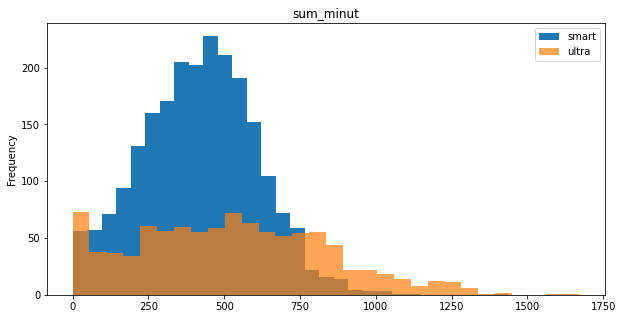

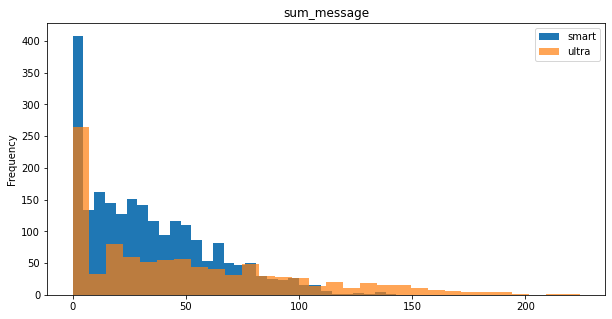

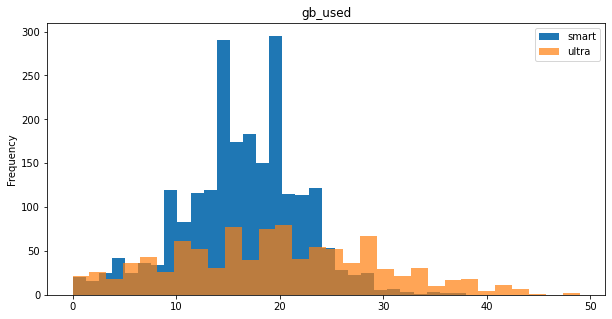

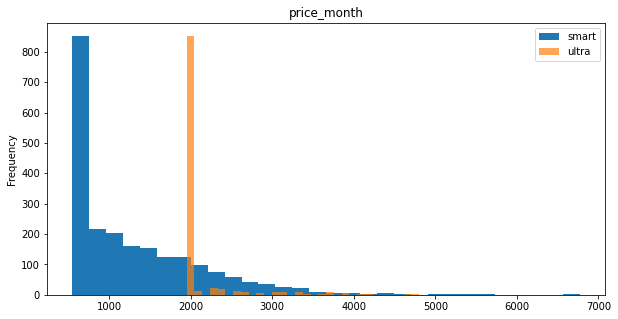

In [876]:
list_of_columns=['sum_minut', 'sum_message', 'gb_used', 'price_month']
tariffs = ['ultra','smart']
for column in list_of_columns:
        data.loc[data.loc[:,'tariff'] == 'smart'][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            label = 'smart', figsize = (10,5)
                                                                           )
        data.loc[data.loc[:,'tariff'] == "ultra"][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            alpha =0.7,
                                                                            label = 'ultra',figsize = (10,5)
                                                                           )
        plt.title(column)
        plt.legend()
        plt.show()

На гистограммах можно заметить что,у тарифа ultra гистограммы скошены вправо, а в тарифе smart гистограммы скошены влево. Это так же подтверждают данные медианы и среднего, приведенные в сводной таблице. Кроме этого можно заметить, что пользователи тарифа ultra не тратят весь базовый пакет минут и количества смс, в отличие от тарифа smart

### Проверка гипотез

#### **Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.**
Пусть нулевая гипотеза звучит так - средние выручки равны - Альтернативная - не равны   

In [877]:
alpha = 0.05

results = st.ttest_ind(ultra['price_month'], smart['price_month'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


**Вывод: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**

 ####  **средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

In [878]:
data_msk=data.query('city == "Москва"')
data_msk.describe()

,user_id,sum_minut,sum_message,gb_used,price_month
count,611.000000,611.000000,611.000000,611.000000,611.000000
mean,1268.872340,469.150573,37.877250,18.050736,1546.713584
std,137.530432,241.535044,37.160304,7.645788,752.088071
min,1001.000000,0.000000,0.000000,1.000000,550.000000
25%,1171.000000,304.000000,6.500000,13.000000,780.500000
50%,1291.000000,453.000000,29.000000,18.000000,1750.000000
75%,1385.000000,620.500000,57.000000,22.000000,1950.000000
max,1490.000000,1321.000000,191.000000,44.000000,5321.000000


In [879]:
data_other=data.query('city != "Москва"')
data_other.describe()

,user_id,sum_minut,sum_message,gb_used,price_month
count,2605.000000,2605.000000,2605.000000,2605.000000,2605.000000
mean,1247.535125,446.698656,38.346641,17.109405,1524.725144
std,145.994150,242.076254,35.915233,7.344701,808.745680
min,1000.000000,0.000000,0.000000,0.000000,550.000000
25%,1120.000000,280.000000,9.000000,13.000000,750.000000
50%,1241.000000,440.000000,30.000000,17.000000,1583.000000
75%,1377.000000,584.000000,57.000000,21.000000,1950.000000
max,1499.000000,1673.000000,224.000000,49.000000,6770.000000


Средние выручки и действительно равны, есть небольшое различие - Пусть нулевая гипотеза звучит так - средние выручки равны - Альтернативная - не равны   

In [880]:
alpha = 0.05

results = st.ttest_ind(data_msk['price_month'], data_other['price_month'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


# Общий вывод

1. Данные  не содержали пропущенных значений, дубликатов не было. В таблице calls была продолжительность 0.0 минут,это не ошибки: нулями обозначены пропущенные звонки, поэтому их не нужно удалять. 
2. Было проанализировано два тарифа Смарт и Ультра. - В СМАРТ входит 50 сообщений, 500 минут, 15 ГБ, абон.плата – 550 руб. - В УЛЬТРА входит 1000 сообщений, 3000 минут, 30 ГБ, абон.плата – 1950 руб. 
**Анализ тарифов сотового оператора** 
 Абоненты в обоих тарифах используют интернет значительно больше лимита.
 Т.е. в лимиты обоих тарифов входит существенная разница по минутам и сообщениям, а интернет отличатся на 15ГБ. Фактически      абоненты обоих тарифов тратят похожее кол-во минут, сообщений абоненты Ультра тратят в среднем немного больше. А интернет абоненты Смарта тратят больше и при этом он для них по более дорогой цене. Более 81% месяцев по тарифу Смарт превышают лимит ГБ в два раза, т.е. за дополнительные 15 ГБ платят 3000. А это значит, что эти 81% - как минимум приносят оператору 3550 рублей при тех же условиях что и тариф УЛЬТРА. Т.е. вместо 1950 получается 3550. А если еще рассмотреть превышение 30 ГБ, то для сотового оператора абоненты Смарта становятся еще более выгодными, ведь они платят по 200 руб. за ГБ, а Ультра 150 руб. за ГБ.  Доп.минуты от абонентов Смарт также приносят прибыль сотовому оператору, а именно 22% от выручке по абон.плате. Получается что тариф, который дешевле почти в 4 раза выручки приносит больше, - средняя выручка от абонента в месяц: - УЛЬТРА – 3844 руб. - СМАРТ – 6247 руб
 
3. Проверка гипотез показывает, что различие это не случайное, а закономерное. Поведение пользователей двух тарифов мало отличается , а расценки разные, отсюда и разность в выручке. Средняя выручка по Москве и другим регионам практически не отличается. 

**Рекомендации** 1. Тариф Смарт приносит больше денег, а значит и корректировать рекламный бюджет надо в его пользу. 2. Сотовому оператору выгоднее подключать абонентов к тарифу Смарт, а так как бОльшую долю выручки приносит доп.интернет, можно уменьшить абон.плату или добавить в этот тариф минуты и сообщения, для привлечения клиентов.